# Load synthetic data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [2]:
import tensorflow as tf
import keras as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

In [4]:
class FeatureScaler(object):
    def __init__(self, train):
        self.mean = train.mean(axis=0)
        self.std = train.std(axis=0)
    
    def transform(self, df):
        return (df - self.mean) / self.std
    
    def inverse_transform(self, df):
        return df * self.std + self.mean
    
    def get_params(self):
        return self.mean, self.std

In [5]:
def build_nn(input_length, hidden_layer_sizes = [20, 10, 5]):
    model = K.models.Sequential()
    kernel_init = K.initializers.RandomNormal(stddev=np.sqrt(2.0/input_length))
    model.add(K.layers.Dense(units=hidden_layer_sizes[0], activation='relu', kernel_initializer=kernel_init, 
                             input_shape=[input_length]))
    for layer_idx in range(1, len(hidden_layer_sizes)):
        kernel_init = K.initializers.RandomNormal(stddev=np.sqrt(2.0/hidden_layer_sizes[layer_idx-1]))
        model.add(K.layers.Dense(units=hidden_layer_sizes[layer_idx], kernel_initializer=kernel_init, activation='relu'))
    kernel_init = K.initializers.RandomNormal(stddev=np.sqrt(2.0/hidden_layer_sizes[-1]))
    model.add(K.layers.Dense(units=1, kernel_initializer=kernel_init, activation='linear'))
    return model

In [6]:
def train_nn(X_train, Y_train, X_val, Y_val, batch_size=128, n_epochs=50, hidden_layer_sizes=[20, 10, 5], verbose=1):
    n_features = X_train.shape[1]
    model = build_nn(n_features, hidden_layer_sizes)
    
    if verbose != 0:
        print("Neural Network Architechture:")
        print(model.summary())
        print('\n')
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=verbose, mode='auto', restore_best_weights=True)
    train_log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, verbose=verbose, 
                          validation_data=(X_val, Y_val), callbacks=[early_stopping])
    
    return model, train_log.history

In [7]:
def plot_learning_history(history):
    plt.figure()
    plt.plot(history['loss'], color='b', marker='o', label='train loss')
    plt.plot(history['val_loss'], color='r', marker='o', label='val loss')
    plt.xlabel("epochs")
    plt.ylabel('loss')
    plt.legend(loc=1)
    plt.show()

# Heston Model Neural Network

## Data Loading and preprocessing

Load generated synthetic data

In [8]:
train = pd.read_csv("./data/heston/train.csv")
val = pd.read_csv("./data/heston/val.csv")
test = pd.read_csv("./data/heston/test.csv")

In [9]:
train.shape, val.shape, test.shape

((900000, 8), (45000, 8), (54411, 8))

In [10]:
train.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0,iv
0,0.820165,0.219184,5.488135,0.689556,3.947543,-0.586746,0.164776,0.637411
1,0.926490,0.212487,7.151894,0.974517,1.495094,-0.407660,0.337974,0.800476
2,0.834318,0.190719,6.027634,0.808059,4.635460,-0.903236,0.203675,0.693484
3,1.053977,0.226441,5.448832,0.180819,4.405048,-0.373840,0.979871,0.662078
4,0.802749,0.208923,4.236548,0.855412,0.250227,-0.108893,0.200594,0.648292


Split input features and labels

In [11]:
X_train_origin, Y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_val_origin, Y_val = val.iloc[:, :-1], val.iloc[:, [-1]]
X_test_origin, Y_test = test.iloc[:, :-1], test.iloc[:, [-1]]

In [12]:
X_train_origin.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0
0,0.820165,0.219184,5.488135,0.689556,3.947543,-0.586746,0.164776
1,0.926490,0.212487,7.151894,0.974517,1.495094,-0.407660,0.337974
2,0.834318,0.190719,6.027634,0.808059,4.635460,-0.903236,0.203675
3,1.053977,0.226441,5.448832,0.180819,4.405048,-0.373840,0.979871
4,0.802749,0.208923,4.236548,0.855412,0.250227,-0.108893,0.200594


In [13]:
Y_train.head()

,iv
0,0.637411
1,0.800476
2,0.693484
3,0.662078
4,0.648292


Normalize features

In [14]:
SCALER = FeatureScaler(X_train_origin)
X_train = SCALER.transform(X_train_origin)
X_val = SCALER.transform(X_val_origin)
X_test = SCALER.transform(X_test_origin)

In [15]:
X_train.shape, Y_train.shape

((900000, 7), (900000, 1))

In [16]:
X_train.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0
0,-0.530693,0.286911,0.167947,0.656690,1.003634,-0.300329,-1.160759
1,0.514788,0.109327,0.744250,1.643183,-0.697421,0.320141,-0.560954
2,-0.391527,-0.467833,0.354822,1.066931,1.480784,-1.396858,-1.026048
3,1.768363,0.479322,0.154333,-1.104483,1.320966,0.437315,1.662005
4,-0.701950,0.014838,-0.265584,1.230858,-1.560880,1.355263,-1.036718


## Neural Network

Define some hyper-parameters

In [17]:
# parameters
hidden_layer_sizes = [20, 10, 5]
batch_size = 128
n_epochs = 50

Build Neural Network, and train it

In [18]:
model, history = train_nn(X_train, Y_train, X_val, Y_val, batch_size, n_epochs, hidden_layer_sizes, verbose=1)

Neural Network Architechture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________
None


Train on 900000 samples, validate on 45000 samples
Epoch 1/50
900000/900000 [==============================] - 37s 41us/step - loss: 0.0055 - val_loss: 4.0644e-04
Epoch 2/50
900000/900000 [==============================] - 32s 36us/step - 

Plot learning history curve

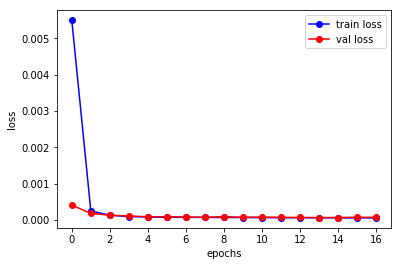

In [19]:
plot_learning_history(history)

Evaluate model performance on test dataset

In [23]:
model.evaluate(X_test, Y_test)

54411/54411 [==============================] - 2s 44us/step


4.330302116670408e-05

Save model to local file for further use, or load a previously trained model

In [21]:
# from keras.models import load_model
# model = load_model('heston.h5')

model.save("heston.h5")

Study the quantiles of the relative error on test dataset

In [24]:
pred_test = model.predict(X_test).flatten()
true_test = Y_test.values.flatten()
relative_error = 100 * np.abs(pred_test - true_test) / true_test

In [25]:
sorted_re = sorted(relative_error)
q_90 = sorted_re[int(0.90*len(relative_error))]
q_95 = sorted_re[int(0.95*len(relative_error))]
q_99 = sorted_re[int(0.99*len(relative_error))]

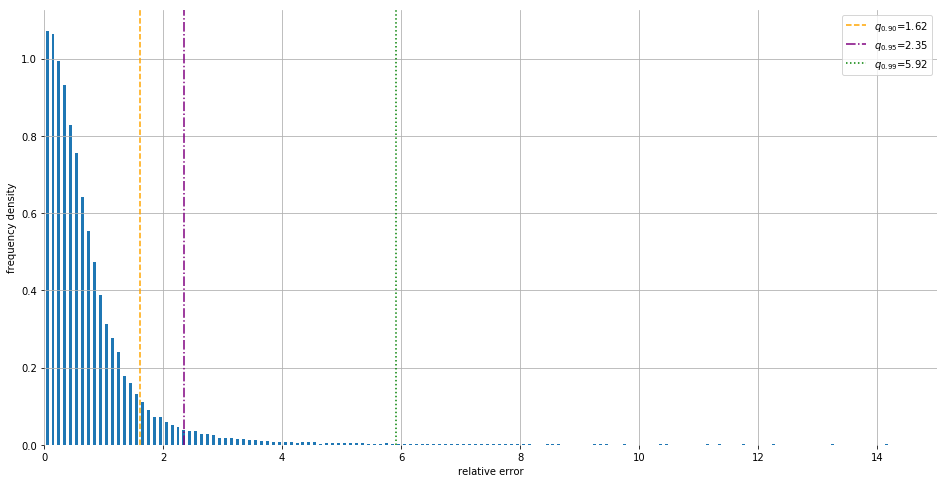

In [26]:
plt.figure(figsize=(16, 8))
plt.hist(relative_error, bins=np.linspace(0, 15, 151), density=True, rwidth=0.5)
plt.xlim((0, 15))
sns.despine(left=True, bottom=True, right=True)
plt.grid(True)
plt.axvline(x=q_90, ls='--', color='orange', label=r"$q_{0.90}$"+"={:.2f}".format(q_90))
plt.axvline(x=q_95, ls='-.', color='purple', label=r"$q_{0.95}$"+"={:.2f}".format(q_95))
plt.axvline(x=q_99, ls=':', color='green', label=r"$q_{0.99}$"+"={:.2f}".format(q_99))
plt.legend(loc=1)
plt.xlabel("relative error")
plt.ylabel("frequency density")
plt.show()

Use a fixed parameter to generate the IV surface

In [27]:
log_moneyness = np.linspace(-0.1, 0.1, 21)
maturity = np.linspace(0.01, 0.18, 18)
log_moneyness, maturity = np.meshgrid(log_moneyness, maturity)

# columns ['Moneyness', 'Time to Maturity (years)', 'lambda', 'vbar', 'eta', 'rho', 'v0']
df = pd.DataFrame(columns=train.columns)
df['Moneyness'] = np.exp(log_moneyness.flatten())
df['Time to Maturity (years)'] = maturity.flatten()
df['eta'] = 0.3877
df['rho'] = -0.7165
df['lambda'] = 1.3253
df['v0'] = 0.0354
df['vbar'] = 0.0174

In [28]:
df.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0,iv
0,0.904837,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,NaN
1,0.913931,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,NaN
2,0.923116,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,NaN
3,0.932394,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,NaN
4,0.941765,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,NaN


In [29]:
from tqdm import tqdm
tqdm.pandas()

from utils import heston_pricer

In [30]:
df['iv'] = df.progress_apply(lambda row: heston_pricer(row['lambda'], row['vbar'], row['eta'], row['rho'], row['v0'], 
                                                       0, 0, row['Time to Maturity (years)'], 1.0, row['Moneyness'])[1], 
                             axis=1)

100%|███████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 200.39it/s]


In [31]:
scaled_features = SCALER.transform(df.iloc[:, :-1])

In [32]:
df['iv_nn'] = model.predict(scaled_features)

In [33]:
df.head()

,Moneyness,Time to Maturity (years),lambda,vbar,eta,rho,v0,iv,iv_nn
0,0.904837,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,0.231526,0.240208
1,0.913931,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,0.228294,0.236603
2,0.923116,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,0.224999,0.232962
3,0.932394,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,0.221641,0.229285
4,0.941765,0.01,1.3253,0.0174,0.3877,-0.7165,0.0354,0.218215,0.225570


In [34]:
df['Log Moneyness'] = log_moneyness.flatten()
df['re'] = np.abs(df['iv_nn'] - df['iv']) / df['iv']

In [37]:
def plot_heatmap(data, values='re'):
    """ Plots the heatmap of the `values` column w.r.t. `Time to Maturity` and `Log Moneyness`.
    """
    data_sort = data.sort_values(values, ascending=True)
    data_pivot = data_sort.pivot(index='Time to Maturity (years)', columns='Log Moneyness', values=values)
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data_pivot, cmap=plt.cm.Spectral, cbar=True, 
                     xticklabels=data_pivot.columns.values.round(2), 
                     yticklabels=data_pivot.index.values.round(2))
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

Plot the heatmap of relative errors

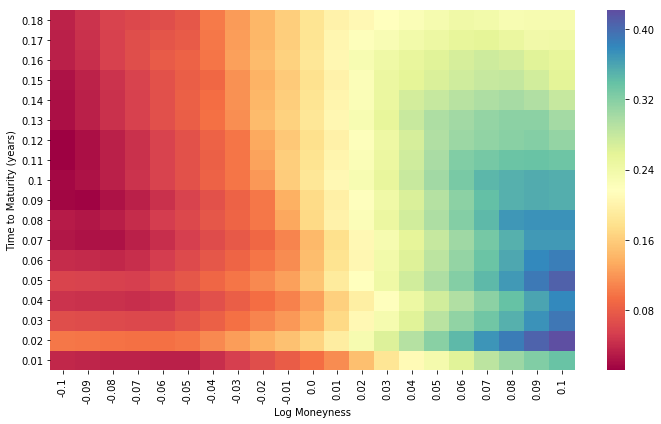

In [38]:
plot_heatmap(df, 're')

Plot IV surface

In [39]:
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

def plot_iv_surface(data, x="Log Moneyness", y='Time to Maturity (years)', z='iv'):
    """ Plots the IV surface
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.gca(projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap = plt.cm.Spectral)
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    plt.tight_layout()
    
    plt.show()

Firstly, the "true" IV surface

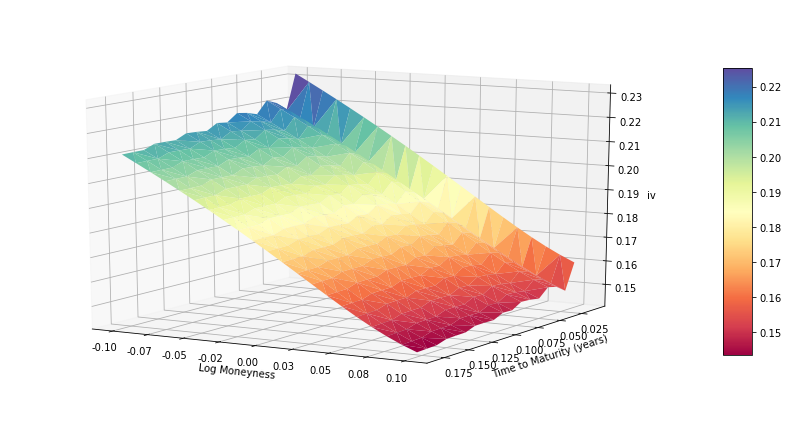

In [298]:
plot_iv_surface(df, z='iv')

Secondly, the "predicted" IV surface

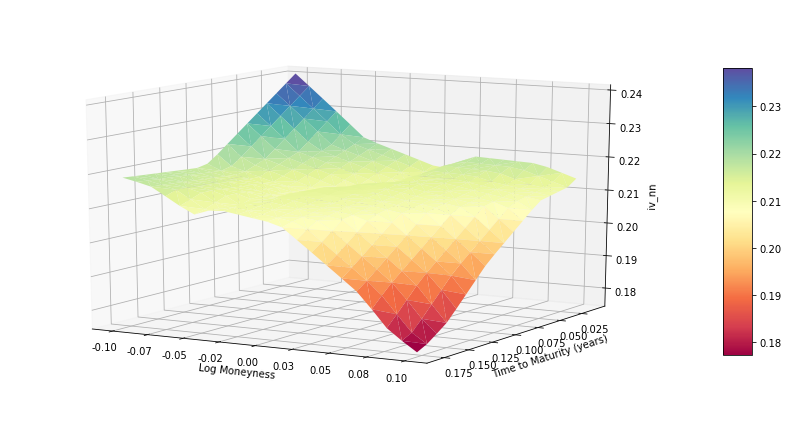

In [40]:
plot_iv_surface(df, z='iv_nn')

----------

----------

# rBergomi Model Neural Network

## Data Loading and preprocessing

Load generated synthetic data

In [41]:
train = pd.read_csv("./data/rBergomi/train.csv")
val = pd.read_csv("./data/rBergomi/val.csv")
test = pd.read_csv("./data/rBergomi/test.csv")

In [42]:
train.shape, val.shape, test.shape

((400000, 7), (50000, 7), (49967, 7))

In [43]:
train.head()

,Moneyness,Time to Maturity (years),H,eta,rho,v0,iv
0,0.820165,0.219184,0.081945,2.255543,-0.684322,0.241298,0.523130
1,0.926490,0.212487,0.024855,2.523325,-0.639780,0.368089,0.538562
2,0.834318,0.190719,0.080699,2.844218,-0.865874,0.495959,0.648789
3,1.053977,0.226441,0.145114,2.459598,-0.662612,0.303747,0.406144
4,0.802749,0.208923,0.106086,2.420046,-0.504125,0.201463,0.493122


Split input features and labels

In [44]:
X_train_origin, Y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_val_origin, Y_val = val.iloc[:, :-1], val.iloc[:, [-1]]
X_test_origin, Y_test = test.iloc[:, :-1], test.iloc[:, [-1]]

In [45]:
X_train_origin.head()

,Moneyness,Time to Maturity (years),H,eta,rho,v0
0,0.820165,0.219184,0.081945,2.255543,-0.684322,0.241298
1,0.926490,0.212487,0.024855,2.523325,-0.639780,0.368089
2,0.834318,0.190719,0.080699,2.844218,-0.865874,0.495959
3,1.053977,0.226441,0.145114,2.459598,-0.662612,0.303747
4,0.802749,0.208923,0.106086,2.420046,-0.504125,0.201463


In [46]:
Y_train.head()

,iv
0,0.523130
1,0.538562
2,0.648789
3,0.406144
4,0.493122


Normalize features

In [47]:
SCALER = FeatureScaler(X_train_origin)
X_train = SCALER.transform(X_train_origin)
X_val = SCALER.transform(X_val_origin)
X_test = SCALER.transform(X_test_origin)

In [48]:
X_train.shape, Y_train.shape

((400000, 6), (400000, 1))

In [49]:
X_train.head()

,Moneyness,Time to Maturity (years),H,eta,rho,v0
0,-0.531228,0.286469,0.023149,-0.499319,1.225160,-0.619535
1,0.514115,0.108372,-1.352500,0.043096,1.602949,0.673947
2,-0.392081,-0.470453,-0.006890,0.693088,-0.314706,1.978441
3,1.767523,0.479435,1.545254,-0.085990,1.409292,0.017551
4,-0.702462,0.013611,0.604837,-0.166104,2.753527,-1.025919


## Neural Network

Define some hyper-parameters

In [50]:
# parameters
hidden_layer_sizes = [20, 10, 5]
batch_size = 128
n_epochs = 50

Build Neural Network and train it

In [51]:
model, history = train_nn(X_train, Y_train, X_val, Y_val, batch_size, n_epochs, hidden_layer_sizes, verbose=1)

Neural Network Architechture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 20)                140       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 411
Trainable params: 411
Non-trainable params: 0
_________________________________________________________________
None


Train on 400000 samples, validate on 50000 samples
Epoch 1/50


379392/400000 [===========================>..] - ETA: 34:30 - loss: 0.57 - ETA: 3:44 - loss: 0.4162 - ETA: 2:06 - loss: 0.377 - ETA: 1:31 - loss: 0.337 - ETA: 1:13 - loss: 0.306 - ETA: 1:02 - loss: 0.281 - ETA: 54s - loss: 0.258 - ETA: 49s - loss: 0.23 - ETA: 46s - loss: 0.22 - ETA: 43s - loss: 0.20 - ETA: 41s - loss: 0.19 - ETA: 38s - loss: 0.18 - ETA: 37s - loss: 0.17 - ETA: 35s - loss: 0.16 - ETA: 34s - loss: 0.15 - ETA: 32s - loss: 0.14 - ETA: 31s - loss: 0.13 - ETA: 30s - loss: 0.13 - ETA: 29s - loss: 0.12 - ETA: 28s - loss: 0.11 - ETA: 28s - loss: 0.11 - ETA: 27s - loss: 0.10 - ETA: 26s - loss: 0.10 - ETA: 26s - loss: 0.09 - ETA: 25s - loss: 0.09 - ETA: 25s - loss: 0.09 - ETA: 25s - loss: 0.09 - ETA: 24s - loss: 0.08 - ETA: 24s - loss: 0.08 - ETA: 24s - loss: 0.08 - ETA: 23s - loss: 0.08 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 23s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.07 - ETA: 22s - loss: 0.06 - ETA: 22s - loss: 0.06 - ETA: 22s - loss: 0.06 - E

400000/400000 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 20s 50us/step - loss: 0.0081 - val_loss: 3.4091e-04
Epoch 2/50


349824/400000 [=========================>....] - ETA: 1:08 - loss: 2.7576e-0 - ETA: 25s - loss: 3.0587e-0 - ETA: 23s - loss: 3.2004e- - ETA: 20s - loss: 3.0518e- - ETA: 20s - loss: 2.9928e- - ETA: 19s - loss: 2.9497e- - ETA: 18s - loss: 2.9788e- - ETA: 18s - loss: 2.9693e- - ETA: 18s - loss: 2.9612e- - ETA: 18s - loss: 2.9433e- - ETA: 17s - loss: 2.9241e- - ETA: 17s - loss: 3.0406e- - ETA: 18s - loss: 2.9997e- - ETA: 18s - loss: 2.9829e- - ETA: 18s - loss: 2.9573e- - ETA: 18s - loss: 2.9370e- - ETA: 18s - loss: 2.9031e- - ETA: 17s - loss: 2.9102e- - ETA: 17s - loss: 2.9456e- - ETA: 17s - loss: 2.9362e- - ETA: 17s - loss: 2.9278e- - ETA: 17s - loss: 2.9344e- - ETA: 17s - loss: 2.9373e- - ETA: 17s - loss: 2.9144e- - ETA: 17s - loss: 2.9882e- - ETA: 16s - loss: 2.9738e- - ETA: 16s - loss: 2.9787e- - ETA: 16s - loss: 2.9771e- - ETA: 16s - loss: 2.9918e- - ETA: 16s - loss: 2.9788e- - ETA: 16s - loss: 2.9607e- - ETA: 16s - loss: 2.9564e- - ETA: 16s - loss: 2.9443e- - ETA: 16s - loss: 2.9250e

400000/400000 [==============================] - ETA: 2s - loss: 2.6274e-0 - ETA: 2s - loss: 2.6255e-0 - ETA: 2s - loss: 2.6256e-0 - ETA: 2s - loss: 2.6249e-0 - ETA: 1s - loss: 2.6219e-0 - ETA: 1s - loss: 2.6196e-0 - ETA: 1s - loss: 2.6211e-0 - ETA: 1s - loss: 2.6172e-0 - ETA: 1s - loss: 2.6140e-0 - ETA: 1s - loss: 2.6113e-0 - ETA: 1s - loss: 2.6089e-0 - ETA: 1s - loss: 2.6056e-0 - ETA: 1s - loss: 2.6016e-0 - ETA: 1s - loss: 2.5993e-0 - ETA: 1s - loss: 2.5975e-0 - ETA: 1s - loss: 2.5944e-0 - ETA: 1s - loss: 2.5915e-0 - ETA: 1s - loss: 2.5916e-0 - ETA: 1s - loss: 2.5893e-0 - ETA: 1s - loss: 2.5859e-0 - ETA: 1s - loss: 2.5843e-0 - ETA: 1s - loss: 2.5856e-0 - ETA: 0s - loss: 2.5839e-0 - ETA: 0s - loss: 2.5819e-0 - ETA: 0s - loss: 2.5798e-0 - ETA: 0s - loss: 2.5774e-0 - ETA: 0s - loss: 2.5745e-0 - ETA: 0s - loss: 2.5729e-0 - ETA: 0s - loss: 2.5702e-0 - ETA: 0s - loss: 2.5677e-0 - ETA: 0s - loss: 2.5669e-0 - ETA: 0s - loss: 2.5641e-0 - ETA: 0s - loss: 2.5605e-0 - ETA: 0s - loss: 2.5574e-0 -

383488/400000 [===========================>..] - ETA: 1:05 - loss: 2.4084e-0 - ETA: 25s - loss: 1.6325e-0 - ETA: 22s - loss: 1.5765e- - ETA: 22s - loss: 2.1086e- - ETA: 21s - loss: 2.0066e- - ETA: 21s - loss: 1.9663e- - ETA: 19s - loss: 1.9351e- - ETA: 19s - loss: 1.9214e- - ETA: 20s - loss: 1.8885e- - ETA: 20s - loss: 1.8896e- - ETA: 20s - loss: 1.8626e- - ETA: 19s - loss: 2.3477e- - ETA: 20s - loss: 2.3396e- - ETA: 20s - loss: 2.3261e- - ETA: 19s - loss: 2.2794e- - ETA: 19s - loss: 2.2306e- - ETA: 19s - loss: 2.1850e- - ETA: 19s - loss: 2.1635e- - ETA: 19s - loss: 2.1218e- - ETA: 19s - loss: 2.0896e- - ETA: 19s - loss: 2.0695e- - ETA: 19s - loss: 2.0600e- - ETA: 19s - loss: 2.2129e- - ETA: 19s - loss: 2.2042e- - ETA: 19s - loss: 2.1888e- - ETA: 19s - loss: 2.1938e- - ETA: 19s - loss: 2.1826e- - ETA: 19s - loss: 2.1790e- - ETA: 19s - loss: 2.1572e- - ETA: 19s - loss: 2.1678e- - ETA: 19s - loss: 2.2785e- - ETA: 19s - loss: 2.2701e- - ETA: 18s - loss: 2.2497e- - ETA: 18s - loss: 2.2269e

400000/400000 [==============================] - ETA: 0s - loss: 1.7952e-0 - ETA: 0s - loss: 1.7935e-0 - ETA: 0s - loss: 1.7918e-0 - ETA: 0s - loss: 1.7893e-0 - ETA: 0s - loss: 1.7921e-0 - ETA: 0s - loss: 1.7921e-0 - ETA: 0s - loss: 1.7900e-0 - ETA: 0s - loss: 1.7894e-0 - ETA: 0s - loss: 1.7874e-0 - ETA: 0s - loss: 1.7860e-0 - ETA: 0s - loss: 1.7844e-0 - 16s 41us/step - loss: 1.7842e-04 - val_loss: 1.9055e-04
Epoch 4/50


400000/400000 [==============================] - ETA: 59s - loss: 1.3833e- - ETA: 16s - loss: 1.4609e- - ETA: 15s - loss: 1.3807e- - ETA: 15s - loss: 1.3429e- - ETA: 15s - loss: 1.3840e- - ETA: 14s - loss: 1.3987e- - ETA: 14s - loss: 1.4562e- - ETA: 14s - loss: 1.4197e- - ETA: 14s - loss: 1.3976e- - ETA: 14s - loss: 1.3857e- - ETA: 14s - loss: 1.3688e- - ETA: 13s - loss: 1.3513e- - ETA: 13s - loss: 1.3443e- - ETA: 13s - loss: 1.3464e- - ETA: 13s - loss: 1.3510e- - ETA: 13s - loss: 1.3397e- - ETA: 13s - loss: 1.3384e- - ETA: 13s - loss: 1.3332e- - ETA: 13s - loss: 1.3202e- - ETA: 13s - loss: 1.3101e- - ETA: 13s - loss: 1.2981e- - ETA: 13s - loss: 1.3044e- - ETA: 13s - loss: 1.3122e- - ETA: 13s - loss: 1.3042e- - ETA: 13s - loss: 1.3078e- - ETA: 13s - loss: 1.3093e- - ETA: 13s - loss: 1.3062e- - ETA: 13s - loss: 1.3040e- - ETA: 13s - loss: 1.3212e- - ETA: 13s - loss: 1.3549e- - ETA: 13s - loss: 1.3696e- - ETA: 13s - loss: 1.3701e- - ETA: 13s - loss: 1.3640e- - ETA: 13s - loss: 1.3637e- -

400000/400000 [==============================] - ETA: 1:02 - loss: 9.5842e-0 - ETA: 17s - loss: 1.2257e-0 - ETA: 16s - loss: 1.0785e- - ETA: 15s - loss: 1.0693e- - ETA: 14s - loss: 1.0484e- - ETA: 14s - loss: 1.0785e- - ETA: 14s - loss: 1.0812e- - ETA: 14s - loss: 1.0945e- - ETA: 14s - loss: 1.0898e- - ETA: 14s - loss: 1.0908e- - ETA: 14s - loss: 1.0801e- - ETA: 13s - loss: 1.0704e- - ETA: 14s - loss: 1.0687e- - ETA: 13s - loss: 1.0632e- - ETA: 13s - loss: 1.0698e- - ETA: 13s - loss: 1.5626e- - ETA: 13s - loss: 1.5596e- - ETA: 13s - loss: 1.5345e- - ETA: 13s - loss: 1.5087e- - ETA: 13s - loss: 1.4959e- - ETA: 13s - loss: 1.4783e- - ETA: 13s - loss: 1.4563e- - ETA: 13s - loss: 1.4463e- - ETA: 13s - loss: 1.4874e- - ETA: 13s - loss: 1.4864e- - ETA: 13s - loss: 1.4777e- - ETA: 13s - loss: 1.4874e- - ETA: 13s - loss: 1.4708e- - ETA: 13s - loss: 1.4520e- - ETA: 13s - loss: 1.4360e- - ETA: 13s - loss: 1.4207e- - ETA: 13s - loss: 1.4058e- - ETA: 13s - loss: 1.3912e- - ETA: 13s - loss: 1.3818e

387968/400000 [============================>.] - ETA: 56s - loss: 1.1992e- - ETA: 16s - loss: 3.0053e- - ETA: 15s - loss: 2.4274e- - ETA: 14s - loss: 1.9888e- - ETA: 14s - loss: 1.7306e- - ETA: 14s - loss: 1.5833e- - ETA: 14s - loss: 1.4748e- - ETA: 14s - loss: 1.3955e- - ETA: 14s - loss: 1.3190e- - ETA: 14s - loss: 1.2574e- - ETA: 14s - loss: 1.2437e- - ETA: 14s - loss: 1.2176e- - ETA: 14s - loss: 1.1910e- - ETA: 14s - loss: 1.1767e- - ETA: 14s - loss: 1.1617e- - ETA: 14s - loss: 1.1491e- - ETA: 14s - loss: 1.1441e- - ETA: 13s - loss: 1.1236e- - ETA: 13s - loss: 1.1116e- - ETA: 13s - loss: 1.1286e- - ETA: 13s - loss: 1.1221e- - ETA: 14s - loss: 1.1201e- - ETA: 13s - loss: 1.1137e- - ETA: 13s - loss: 1.1020e- - ETA: 13s - loss: 1.0906e- - ETA: 13s - loss: 1.2197e- - ETA: 13s - loss: 1.2204e- - ETA: 13s - loss: 1.2214e- - ETA: 13s - loss: 1.2144e- - ETA: 13s - loss: 1.2036e- - ETA: 13s - loss: 1.1959e- - ETA: 13s - loss: 1.1824e- - ETA: 13s - loss: 1.1710e- - ETA: 13s - loss: 1.2069e- -

400000/400000 [==============================] - ETA: 0s - loss: 1.1463e-0 - ETA: 0s - loss: 1.1452e-0 - ETA: 0s - loss: 1.1436e-0 - ETA: 0s - loss: 1.1431e-0 - ETA: 0s - loss: 1.1497e-0 - ETA: 0s - loss: 1.1498e-0 - ETA: 0s - loss: 1.1486e-0 - 16s 41us/step - loss: 1.1489e-04 - val_loss: 1.3079e-04
Epoch 7/50


400000/400000 [==============================] - ETA: 1:02 - loss: 1.0791e-0 - ETA: 18s - loss: 8.2966e-0 - ETA: 16s - loss: 7.6563e- - ETA: 15s - loss: 1.4129e- - ETA: 15s - loss: 1.2729e- - ETA: 14s - loss: 1.2641e- - ETA: 14s - loss: 1.1976e- - ETA: 14s - loss: 1.1456e- - ETA: 15s - loss: 1.1115e- - ETA: 15s - loss: 1.0919e- - ETA: 15s - loss: 1.0592e- - ETA: 15s - loss: 1.0627e- - ETA: 15s - loss: 1.0422e- - ETA: 15s - loss: 1.0193e- - ETA: 15s - loss: 1.0000e- - ETA: 15s - loss: 9.8314e- - ETA: 14s - loss: 9.9548e- - ETA: 14s - loss: 1.0081e- - ETA: 14s - loss: 9.9100e- - ETA: 14s - loss: 9.8137e- - ETA: 14s - loss: 9.7872e- - ETA: 14s - loss: 9.6624e- - ETA: 14s - loss: 9.5554e- - ETA: 14s - loss: 9.4770e- - ETA: 14s - loss: 9.3879e- - ETA: 14s - loss: 9.2917e- - ETA: 14s - loss: 9.4844e- - ETA: 13s - loss: 9.6729e- - ETA: 13s - loss: 9.6087e- - ETA: 13s - loss: 9.5775e- - ETA: 13s - loss: 9.5668e- - ETA: 13s - loss: 9.7340e- - ETA: 13s - loss: 9.7440e- - ETA: 13s - loss: 9.7608e

400000/400000 [==============================] - ETA: 56s - loss: 5.6713e- - ETA: 16s - loss: 1.0377e- - ETA: 15s - loss: 9.0124e- - ETA: 15s - loss: 9.0628e- - ETA: 15s - loss: 8.6671e- - ETA: 14s - loss: 8.6095e- - ETA: 14s - loss: 8.7966e- - ETA: 14s - loss: 8.6584e- - ETA: 14s - loss: 9.2113e- - ETA: 14s - loss: 9.1053e- - ETA: 14s - loss: 9.3313e- - ETA: 14s - loss: 9.1484e- - ETA: 14s - loss: 9.0216e- - ETA: 14s - loss: 8.9160e- - ETA: 14s - loss: 9.0177e- - ETA: 14s - loss: 9.5962e- - ETA: 14s - loss: 9.5966e- - ETA: 14s - loss: 9.5042e- - ETA: 13s - loss: 9.4188e- - ETA: 13s - loss: 9.3713e- - ETA: 13s - loss: 9.2851e- - ETA: 13s - loss: 1.2259e- - ETA: 13s - loss: 1.2585e- - ETA: 13s - loss: 1.2431e- - ETA: 13s - loss: 1.2248e- - ETA: 13s - loss: 1.2073e- - ETA: 13s - loss: 1.1921e- - ETA: 13s - loss: 1.1773e- - ETA: 13s - loss: 1.1658e- - ETA: 13s - loss: 1.1769e- - ETA: 13s - loss: 1.1681e- - ETA: 13s - loss: 1.1537e- - ETA: 12s - loss: 1.1469e- - ETA: 12s - loss: 1.1603e- -

400000/400000 [==============================] - ETA: 59s - loss: 5.4085e- - ETA: 16s - loss: 8.5446e- - ETA: 16s - loss: 9.4135e- - ETA: 15s - loss: 1.0010e- - ETA: 14s - loss: 1.2135e- - ETA: 14s - loss: 1.2272e- - ETA: 14s - loss: 1.1318e- - ETA: 14s - loss: 1.2195e- - ETA: 14s - loss: 1.1669e- - ETA: 14s - loss: 1.1600e- - ETA: 14s - loss: 1.1248e- - ETA: 13s - loss: 1.1387e- - ETA: 13s - loss: 1.3293e- - ETA: 13s - loss: 1.3076e- - ETA: 13s - loss: 1.3958e- - ETA: 13s - loss: 1.3561e- - ETA: 13s - loss: 1.3136e- - ETA: 13s - loss: 1.2793e- - ETA: 13s - loss: 1.2871e- - ETA: 13s - loss: 1.2644e- - ETA: 13s - loss: 1.2409e- - ETA: 13s - loss: 1.2218e- - ETA: 13s - loss: 1.2875e- - ETA: 12s - loss: 1.2736e- - ETA: 12s - loss: 1.2758e- - ETA: 12s - loss: 1.2569e- - ETA: 12s - loss: 1.2538e- - ETA: 12s - loss: 1.2375e- - ETA: 12s - loss: 1.2447e- - ETA: 12s - loss: 1.2333e- - ETA: 12s - loss: 1.2166e- - ETA: 12s - loss: 1.2024e- - ETA: 12s - loss: 1.1881e- - ETA: 12s - loss: 1.1947e- -

391296/400000 [============================>.] - ETA: 1:05 - loss: 7.1311e-0 - ETA: 17s - loss: 1.0795e-0 - ETA: 15s - loss: 8.8138e- - ETA: 15s - loss: 8.3131e- - ETA: 14s - loss: 7.9320e- - ETA: 14s - loss: 7.7888e- - ETA: 14s - loss: 7.5857e- - ETA: 14s - loss: 7.4257e- - ETA: 14s - loss: 7.5423e- - ETA: 14s - loss: 7.4684e- - ETA: 14s - loss: 7.5101e- - ETA: 14s - loss: 7.9535e- - ETA: 14s - loss: 7.9105e- - ETA: 14s - loss: 7.8390e- - ETA: 14s - loss: 8.0378e- - ETA: 14s - loss: 7.9708e- - ETA: 14s - loss: 7.9217e- - ETA: 13s - loss: 8.3537e- - ETA: 13s - loss: 8.4512e- - ETA: 13s - loss: 8.3877e- - ETA: 13s - loss: 8.3566e- - ETA: 13s - loss: 8.3133e- - ETA: 13s - loss: 8.2157e- - ETA: 13s - loss: 8.1345e- - ETA: 13s - loss: 8.0916e- - ETA: 13s - loss: 8.4423e- - ETA: 13s - loss: 8.3784e- - ETA: 13s - loss: 8.8666e- - ETA: 13s - loss: 8.8236e- - ETA: 13s - loss: 8.7456e- - ETA: 13s - loss: 8.7224e- - ETA: 13s - loss: 8.6874e- - ETA: 13s - loss: 8.6930e- - ETA: 12s - loss: 8.6387e

400000/400000 [==============================] - ETA: 0s - loss: 1.0016e-0 - ETA: 0s - loss: 1.0003e-0 - ETA: 0s - loss: 9.9948e-0 - ETA: 0s - loss: 1.0010e-0 - ETA: 0s - loss: 1.0003e-0 - ETA: 0s - loss: 9.9956e-0 - ETA: 0s - loss: 9.9996e-0 - 16s 41us/step - loss: 9.9989e-05 - val_loss: 1.1260e-04
Epoch 11/50
400000/400000 [==============================] - ETA: 59s - loss: 5.2848e- - ETA: 15s - loss: 9.2711e- - ETA: 14s - loss: 8.1518e- - ETA: 14s - loss: 8.1275e- - ETA: 14s - loss: 7.8772e- - ETA: 14s - loss: 7.7441e- - ETA: 13s - loss: 7.8550e- - ETA: 13s - loss: 7.7397e- - ETA: 14s - loss: 7.6605e- - ETA: 14s - loss: 7.6386e- - ETA: 14s - loss: 7.7179e- - ETA: 14s - loss: 7.6063e- - ETA: 14s - loss: 7.6907e- - ETA: 14s - loss: 7.7636e- - ETA: 14s - loss: 7.7455e- - ETA: 14s - loss: 7.7611e- - ETA: 13s - loss: 7.7498e- - ETA: 13s - loss: 7.6818e- - ETA: 13s - loss: 7.6249e- - ETA: 13s - loss: 7.6447e- - ETA: 13s - loss: 7.5978e- - ETA: 13s - loss: 7.5432e- - ETA: 13s - loss: 7.642

400000/400000 [==============================] - ETA: 56s - loss: 6.6774e- - ETA: 15s - loss: 1.8586e- - ETA: 16s - loss: 1.5505e- - ETA: 15s - loss: 1.3163e- - ETA: 14s - loss: 1.1975e- - ETA: 14s - loss: 1.0720e- - ETA: 14s - loss: 1.0146e- - ETA: 13s - loss: 9.7792e- - ETA: 13s - loss: 9.5897e- - ETA: 13s - loss: 9.4159e- - ETA: 13s - loss: 9.4466e- - ETA: 13s - loss: 9.3198e- - ETA: 13s - loss: 9.1953e- - ETA: 13s - loss: 9.1770e- - ETA: 12s - loss: 9.0689e- - ETA: 12s - loss: 8.9090e- - ETA: 12s - loss: 9.1267e- - ETA: 12s - loss: 8.9754e- - ETA: 12s - loss: 8.9513e- - ETA: 12s - loss: 8.8365e- - ETA: 12s - loss: 8.7312e- - ETA: 12s - loss: 8.6865e- - ETA: 12s - loss: 8.6702e- - ETA: 12s - loss: 8.6103e- - ETA: 12s - loss: 8.5227e- - ETA: 12s - loss: 8.8672e- - ETA: 12s - loss: 8.8038e- - ETA: 12s - loss: 8.7808e- - ETA: 12s - loss: 8.7556e- - ETA: 12s - loss: 8.7271e- - ETA: 12s - loss: 8.6732e- - ETA: 12s - loss: 8.6551e- - ETA: 11s - loss: 8.5996e- - ETA: 11s - loss: 8.5757e- -

400000/400000 [==============================] - ETA: 1:02 - loss: 4.7883e-0 - ETA: 20s - loss: 1.1759e-0 - ETA: 18s - loss: 1.0903e- - ETA: 16s - loss: 9.8039e- - ETA: 15s - loss: 1.0764e- - ETA: 15s - loss: 1.0150e- - ETA: 15s - loss: 9.8384e- - ETA: 14s - loss: 9.4055e- - ETA: 14s - loss: 9.0178e- - ETA: 14s - loss: 8.7642e- - ETA: 14s - loss: 8.6196e- - ETA: 14s - loss: 8.8905e- - ETA: 14s - loss: 8.8251e- - ETA: 14s - loss: 9.2298e- - ETA: 13s - loss: 9.1345e- - ETA: 14s - loss: 9.0593e- - ETA: 13s - loss: 8.9273e- - ETA: 13s - loss: 8.7968e- - ETA: 13s - loss: 9.1236e- - ETA: 13s - loss: 9.0141e- - ETA: 13s - loss: 8.9102e- - ETA: 13s - loss: 8.8241e- - ETA: 13s - loss: 8.7234e- - ETA: 13s - loss: 8.6671e- - ETA: 13s - loss: 8.6154e- - ETA: 13s - loss: 9.1552e- - ETA: 13s - loss: 9.0573e- - ETA: 13s - loss: 8.9620e- - ETA: 12s - loss: 9.0310e- - ETA: 12s - loss: 8.9225e- - ETA: 12s - loss: 8.8554e- - ETA: 12s - loss: 8.8948e- - ETA: 12s - loss: 9.2671e- - ETA: 12s - loss: 9.2068e

400000/400000 [==============================] - ETA: 1:02 - loss: 7.1710e-0 - ETA: 16s - loss: 8.1839e-0 - ETA: 15s - loss: 7.2893e- - ETA: 14s - loss: 7.2597e- - ETA: 14s - loss: 7.2973e- - ETA: 14s - loss: 7.3397e- - ETA: 14s - loss: 7.1228e- - ETA: 13s - loss: 7.0370e- - ETA: 13s - loss: 7.0287e- - ETA: 14s - loss: 7.0715e- - ETA: 14s - loss: 7.1273e- - ETA: 14s - loss: 7.1119e- - ETA: 13s - loss: 7.0856e- - ETA: 13s - loss: 7.2153e- - ETA: 14s - loss: 7.2510e- - ETA: 14s - loss: 7.3754e- - ETA: 14s - loss: 7.4332e- - ETA: 14s - loss: 7.3796e- - ETA: 14s - loss: 7.3355e- - ETA: 14s - loss: 8.0930e- - ETA: 14s - loss: 8.0702e- - ETA: 15s - loss: 8.0254e- - ETA: 15s - loss: 8.0173e- - ETA: 15s - loss: 7.9771e- - ETA: 16s - loss: 7.9940e- - ETA: 16s - loss: 7.9744e- - ETA: 16s - loss: 8.2508e- - ETA: 16s - loss: 8.2167e- - ETA: 16s - loss: 8.1890e- - ETA: 16s - loss: 8.1872e- - ETA: 16s - loss: 8.1569e- - ETA: 16s - loss: 8.1438e- - ETA: 16s - loss: 8.2511e- - ETA: 16s - loss: 8.1986e

400000/400000 [==============================] - ETA: 1:02 - loss: 4.6705e-0 - ETA: 17s - loss: 6.9445e-0 - ETA: 15s - loss: 6.8365e- - ETA: 14s - loss: 8.0458e- - ETA: 14s - loss: 7.7940e- - ETA: 14s - loss: 7.6272e- - ETA: 14s - loss: 9.1467e- - ETA: 14s - loss: 8.8474e- - ETA: 13s - loss: 8.7453e- - ETA: 13s - loss: 8.5729e- - ETA: 13s - loss: 8.3291e- - ETA: 13s - loss: 8.1834e- - ETA: 13s - loss: 8.1187e- - ETA: 13s - loss: 8.0406e- - ETA: 13s - loss: 8.0656e- - ETA: 13s - loss: 8.1072e- - ETA: 13s - loss: 8.0480e- - ETA: 12s - loss: 8.0604e- - ETA: 12s - loss: 8.0420e- - ETA: 12s - loss: 8.2244e- - ETA: 12s - loss: 8.2612e- - ETA: 12s - loss: 8.1953e- - ETA: 12s - loss: 8.1366e- - ETA: 12s - loss: 8.1322e- - ETA: 12s - loss: 8.1406e- - ETA: 12s - loss: 8.1109e- - ETA: 12s - loss: 8.0692e- - ETA: 12s - loss: 1.0678e- - ETA: 12s - loss: 1.1036e- - ETA: 12s - loss: 1.0941e- - ETA: 12s - loss: 1.1096e- - ETA: 12s - loss: 1.1006e- - ETA: 12s - loss: 1.0877e- - ETA: 12s - loss: 1.0837e

400000/400000 [==============================] - ETA: 1:05 - loss: 7.3903e-0 - ETA: 17s - loss: 1.9032e-0 - ETA: 15s - loss: 2.3782e- - ETA: 14s - loss: 2.0330e- - ETA: 14s - loss: 1.6954e- - ETA: 14s - loss: 1.5519e- - ETA: 13s - loss: 1.4051e- - ETA: 13s - loss: 1.3148e- - ETA: 13s - loss: 1.2280e- - ETA: 13s - loss: 1.3443e- - ETA: 13s - loss: 1.2967e- - ETA: 13s - loss: 1.2541e- - ETA: 13s - loss: 1.2206e- - ETA: 13s - loss: 1.1838e- - ETA: 12s - loss: 1.1483e- - ETA: 12s - loss: 1.1158e- - ETA: 12s - loss: 1.0894e- - ETA: 12s - loss: 1.0610e- - ETA: 12s - loss: 1.0386e- - ETA: 12s - loss: 1.0387e- - ETA: 12s - loss: 1.0277e- - ETA: 12s - loss: 1.0226e- - ETA: 12s - loss: 1.0367e- - ETA: 12s - loss: 1.0473e- - ETA: 12s - loss: 1.0337e- - ETA: 12s - loss: 1.1663e- - ETA: 12s - loss: 1.1510e- - ETA: 12s - loss: 1.1334e- - ETA: 12s - loss: 1.1671e- - ETA: 12s - loss: 1.1521e- - ETA: 12s - loss: 1.1345e- - ETA: 11s - loss: 1.1199e- - ETA: 11s - loss: 1.1242e- - ETA: 11s - loss: 1.1215e

400000/400000 [==============================] - ETA: 1:02 - loss: 6.8704e-0 - ETA: 18s - loss: 7.5762e-0 - ETA: 16s - loss: 7.0026e- - ETA: 15s - loss: 7.1599e- - ETA: 15s - loss: 7.1370e- - ETA: 15s - loss: 7.1524e- - ETA: 15s - loss: 7.1486e- - ETA: 14s - loss: 7.1895e- - ETA: 15s - loss: 7.1706e- - ETA: 14s - loss: 7.7640e- - ETA: 14s - loss: 1.0937e- - ETA: 14s - loss: 1.1656e- - ETA: 14s - loss: 1.1749e- - ETA: 14s - loss: 1.1733e- - ETA: 14s - loss: 1.1731e- - ETA: 14s - loss: 1.1338e- - ETA: 14s - loss: 1.0994e- - ETA: 14s - loss: 1.0773e- - ETA: 14s - loss: 1.0531e- - ETA: 14s - loss: 1.0573e- - ETA: 13s - loss: 1.0349e- - ETA: 13s - loss: 1.0163e- - ETA: 13s - loss: 9.9558e- - ETA: 13s - loss: 9.8374e- - ETA: 13s - loss: 9.8036e- - ETA: 13s - loss: 9.7424e- - ETA: 13s - loss: 9.6243e- - ETA: 13s - loss: 9.4757e- - ETA: 13s - loss: 9.4467e- - ETA: 13s - loss: 9.3469e- - ETA: 13s - loss: 9.2967e- - ETA: 13s - loss: 1.1193e- - ETA: 12s - loss: 1.1127e- - ETA: 12s - loss: 1.1050e

400000/400000 [==============================] - ETA: 56s - loss: 1.1272e- - ETA: 15s - loss: 6.9762e- - ETA: 14s - loss: 6.8350e- - ETA: 14s - loss: 6.5196e- - ETA: 13s - loss: 6.8279e- - ETA: 13s - loss: 6.8248e- - ETA: 13s - loss: 7.9347e- - ETA: 13s - loss: 9.1984e- - ETA: 13s - loss: 1.0345e- - ETA: 13s - loss: 1.0162e- - ETA: 13s - loss: 9.7990e- - ETA: 13s - loss: 9.5059e- - ETA: 13s - loss: 9.2221e- - ETA: 13s - loss: 9.0103e- - ETA: 13s - loss: 8.8761e- - ETA: 12s - loss: 8.6806e- - ETA: 12s - loss: 8.5800e- - ETA: 12s - loss: 8.6488e- - ETA: 12s - loss: 8.5253e- - ETA: 12s - loss: 8.4347e- - ETA: 12s - loss: 8.3464e- - ETA: 12s - loss: 8.3344e- - ETA: 12s - loss: 8.3373e- - ETA: 12s - loss: 8.2464e- - ETA: 12s - loss: 8.1785e- - ETA: 12s - loss: 8.1100e- - ETA: 12s - loss: 8.0692e- - ETA: 12s - loss: 8.0067e- - ETA: 12s - loss: 8.4419e- - ETA: 11s - loss: 8.6672e- - ETA: 11s - loss: 8.5986e- - ETA: 11s - loss: 8.5420e- - ETA: 11s - loss: 8.5235e- - ETA: 11s - loss: 8.4925e- -

400000/400000 [==============================] - ETA: 56s - loss: 5.7906e- - ETA: 15s - loss: 6.6530e- - ETA: 14s - loss: 6.5720e- - ETA: 14s - loss: 6.2826e- - ETA: 14s - loss: 6.3696e- - ETA: 14s - loss: 6.3018e- - ETA: 14s - loss: 6.6698e- - ETA: 13s - loss: 8.5874e- - ETA: 13s - loss: 8.4669e- - ETA: 13s - loss: 8.3588e- - ETA: 13s - loss: 8.1996e- - ETA: 13s - loss: 8.2717e- - ETA: 13s - loss: 8.1485e- - ETA: 13s - loss: 8.1673e- - ETA: 13s - loss: 8.2397e- - ETA: 12s - loss: 8.2856e- - ETA: 12s - loss: 8.2799e- - ETA: 12s - loss: 8.2172e- - ETA: 12s - loss: 8.1616e- - ETA: 12s - loss: 8.0490e- - ETA: 12s - loss: 8.0684e- - ETA: 12s - loss: 7.9785e- - ETA: 12s - loss: 7.9064e- - ETA: 12s - loss: 8.0106e- - ETA: 12s - loss: 7.9465e- - ETA: 12s - loss: 7.8763e- - ETA: 12s - loss: 7.8480e- - ETA: 12s - loss: 7.8124e- - ETA: 12s - loss: 7.8861e- - ETA: 12s - loss: 7.8674e- - ETA: 12s - loss: 7.8132e- - ETA: 12s - loss: 7.8041e- - ETA: 12s - loss: 7.8063e- - ETA: 12s - loss: 7.7823e- -

400000/400000 [==============================] - ETA: 59s - loss: 6.7732e- - ETA: 16s - loss: 6.2490e- - ETA: 14s - loss: 6.9554e- - ETA: 13s - loss: 7.1389e- - ETA: 13s - loss: 7.2864e- - ETA: 13s - loss: 7.3184e- - ETA: 13s - loss: 7.2778e- - ETA: 13s - loss: 8.6007e- - ETA: 13s - loss: 8.4892e- - ETA: 13s - loss: 8.3324e- - ETA: 13s - loss: 8.3394e- - ETA: 13s - loss: 8.2391e- - ETA: 13s - loss: 8.1285e- - ETA: 12s - loss: 7.9623e- - ETA: 12s - loss: 7.8937e- - ETA: 12s - loss: 8.1149e- - ETA: 12s - loss: 8.0267e- - ETA: 12s - loss: 7.9843e- - ETA: 12s - loss: 7.8893e- - ETA: 12s - loss: 7.8240e- - ETA: 12s - loss: 7.7367e- - ETA: 12s - loss: 7.6752e- - ETA: 12s - loss: 7.5937e- - ETA: 12s - loss: 7.5918e- - ETA: 12s - loss: 7.6060e- - ETA: 12s - loss: 7.6395e- - ETA: 12s - loss: 7.6084e- - ETA: 12s - loss: 7.6204e- - ETA: 12s - loss: 7.6059e- - ETA: 12s - loss: 7.5864e- - ETA: 12s - loss: 7.7127e- - ETA: 12s - loss: 7.7205e- - ETA: 12s - loss: 7.7050e- - ETA: 12s - loss: 7.6784e- -

400000/400000 [==============================] - ETA: 52s - loss: 6.1859e- - ETA: 15s - loss: 7.5203e- - ETA: 14s - loss: 9.7756e- - ETA: 14s - loss: 8.7691e- - ETA: 14s - loss: 8.4047e- - ETA: 13s - loss: 9.3360e- - ETA: 13s - loss: 9.0135e- - ETA: 13s - loss: 9.0300e- - ETA: 13s - loss: 8.7080e- - ETA: 13s - loss: 8.5619e- - ETA: 13s - loss: 8.3560e- - ETA: 13s - loss: 8.1889e- - ETA: 13s - loss: 8.1183e- - ETA: 13s - loss: 8.0811e- - ETA: 13s - loss: 8.0728e- - ETA: 14s - loss: 7.9631e- - ETA: 14s - loss: 7.9556e- - ETA: 13s - loss: 7.8408e- - ETA: 13s - loss: 7.7720e- - ETA: 13s - loss: 7.7137e- - ETA: 13s - loss: 7.6989e- - ETA: 13s - loss: 7.6799e- - ETA: 13s - loss: 7.7194e- - ETA: 13s - loss: 7.6715e- - ETA: 13s - loss: 7.6326e- - ETA: 13s - loss: 7.5836e- - ETA: 13s - loss: 7.5261e- - ETA: 12s - loss: 7.4851e- - ETA: 12s - loss: 7.4343e- - ETA: 12s - loss: 7.9806e- - ETA: 12s - loss: 9.2044e- - ETA: 12s - loss: 9.2473e- - ETA: 12s - loss: 9.1612e- - ETA: 12s - loss: 9.0999e- -

400000/400000 [==============================] - ETA: 59s - loss: 6.8912e- - ETA: 16s - loss: 7.4413e- - ETA: 14s - loss: 6.9147e- - ETA: 15s - loss: 6.7971e- - ETA: 15s - loss: 6.9757e- - ETA: 14s - loss: 7.0954e- - ETA: 14s - loss: 7.0613e- - ETA: 14s - loss: 7.0149e- - ETA: 14s - loss: 6.9323e- - ETA: 13s - loss: 1.5354e- - ETA: 13s - loss: 1.5224e- - ETA: 13s - loss: 1.4829e- - ETA: 13s - loss: 1.4552e- - ETA: 13s - loss: 1.4043e- - ETA: 13s - loss: 1.3543e- - ETA: 13s - loss: 1.3150e- - ETA: 13s - loss: 1.3265e- - ETA: 12s - loss: 1.2922e- - ETA: 12s - loss: 1.2658e- - ETA: 12s - loss: 1.2484e- - ETA: 12s - loss: 1.2424e- - ETA: 12s - loss: 1.2193e- - ETA: 12s - loss: 1.2057e- - ETA: 12s - loss: 1.1807e- - ETA: 12s - loss: 1.1625e- - ETA: 12s - loss: 1.1405e- - ETA: 12s - loss: 1.1407e- - ETA: 12s - loss: 1.1193e- - ETA: 12s - loss: 1.0999e- - ETA: 12s - loss: 1.0874e- - ETA: 12s - loss: 1.0724e- - ETA: 12s - loss: 1.0592e- - ETA: 12s - loss: 1.0445e- - ETA: 12s - loss: 1.0335e- -

400000/400000 [==============================] - ETA: 59s - loss: 5.3836e- - ETA: 15s - loss: 1.2108e- - ETA: 15s - loss: 9.7526e- - ETA: 14s - loss: 9.0171e- - ETA: 14s - loss: 8.2905e- - ETA: 13s - loss: 8.0954e- - ETA: 13s - loss: 7.7791e- - ETA: 13s - loss: 7.5387e- - ETA: 13s - loss: 7.6676e- - ETA: 13s - loss: 7.6207e- - ETA: 14s - loss: 7.4817e- - ETA: 13s - loss: 8.3168e- - ETA: 13s - loss: 8.1862e- - ETA: 13s - loss: 8.0750e- - ETA: 13s - loss: 8.3861e- - ETA: 13s - loss: 8.3643e- - ETA: 13s - loss: 8.2556e- - ETA: 13s - loss: 8.1193e- - ETA: 13s - loss: 8.0212e- - ETA: 13s - loss: 7.9399e- - ETA: 13s - loss: 7.8630e- - ETA: 13s - loss: 7.9541e- - ETA: 13s - loss: 7.9019e- - ETA: 13s - loss: 7.8609e- - ETA: 13s - loss: 8.0402e- - ETA: 13s - loss: 8.1570e- - ETA: 13s - loss: 8.1217e- - ETA: 13s - loss: 8.0949e- - ETA: 13s - loss: 8.2261e- - ETA: 13s - loss: 8.1626e- - ETA: 13s - loss: 8.1083e- - ETA: 13s - loss: 9.3655e- - ETA: 13s - loss: 9.3391e- - ETA: 13s - loss: 9.7596e- -

400000/400000 [==============================] - ETA: 56s - loss: 5.2254e- - ETA: 15s - loss: 6.5681e- - ETA: 14s - loss: 6.5698e- - ETA: 13s - loss: 7.1210e- - ETA: 13s - loss: 6.9996e- - ETA: 13s - loss: 7.7920e- - ETA: 13s - loss: 7.5594e- - ETA: 13s - loss: 7.5426e- - ETA: 13s - loss: 9.2622e- - ETA: 13s - loss: 8.9994e- - ETA: 13s - loss: 8.7223e- - ETA: 13s - loss: 8.6119e- - ETA: 13s - loss: 8.7199e- - ETA: 13s - loss: 8.5608e- - ETA: 12s - loss: 8.3998e- - ETA: 12s - loss: 8.3459e- - ETA: 12s - loss: 8.3489e- - ETA: 12s - loss: 8.2578e- - ETA: 12s - loss: 1.0120e- - ETA: 12s - loss: 9.9434e- - ETA: 12s - loss: 9.8907e- - ETA: 12s - loss: 9.7657e- - ETA: 12s - loss: 9.6333e- - ETA: 12s - loss: 9.6656e- - ETA: 12s - loss: 9.6609e- - ETA: 12s - loss: 9.5347e- - ETA: 12s - loss: 9.4304e- - ETA: 12s - loss: 9.3395e- - ETA: 12s - loss: 9.2584e- - ETA: 12s - loss: 9.1822e- - ETA: 12s - loss: 9.0817e- - ETA: 12s - loss: 8.9946e- - ETA: 12s - loss: 8.9259e- - ETA: 11s - loss: 8.8721e- -

400000/400000 [==============================] - ETA: 1:02 - loss: 7.3202e-0 - ETA: 15s - loss: 9.6384e-0 - ETA: 14s - loss: 1.4730e- - ETA: 14s - loss: 1.2340e- - ETA: 13s - loss: 1.1734e- - ETA: 13s - loss: 1.1819e- - ETA: 13s - loss: 1.0953e- - ETA: 13s - loss: 1.0566e- - ETA: 13s - loss: 9.9899e- - ETA: 13s - loss: 9.6581e- - ETA: 13s - loss: 9.3604e- - ETA: 13s - loss: 9.0920e- - ETA: 13s - loss: 8.9013e- - ETA: 13s - loss: 8.7327e- - ETA: 13s - loss: 8.5346e- - ETA: 13s - loss: 8.3520e- - ETA: 13s - loss: 8.2554e- - ETA: 13s - loss: 8.1972e- - ETA: 13s - loss: 8.2664e- - ETA: 13s - loss: 8.2417e- - ETA: 13s - loss: 8.1576e- - ETA: 13s - loss: 8.0841e- - ETA: 13s - loss: 8.0352e- - ETA: 13s - loss: 8.0121e- - ETA: 12s - loss: 7.9767e- - ETA: 12s - loss: 7.9740e- - ETA: 12s - loss: 7.9368e- - ETA: 12s - loss: 7.8785e- - ETA: 12s - loss: 7.9277e- - ETA: 12s - loss: 7.9748e- - ETA: 13s - loss: 7.9625e- - ETA: 13s - loss: 7.9448e- - ETA: 13s - loss: 7.9247e- - ETA: 13s - loss: 7.8942e

400000/400000 [==============================] - ETA: 1:11 - loss: 9.8761e-0 - ETA: 17s - loss: 7.8260e-0 - ETA: 15s - loss: 7.4544e- - ETA: 14s - loss: 7.2459e- - ETA: 14s - loss: 7.4764e- - ETA: 13s - loss: 7.4234e- - ETA: 13s - loss: 7.3185e- - ETA: 13s - loss: 7.1562e- - ETA: 13s - loss: 7.0307e- - ETA: 13s - loss: 6.9849e- - ETA: 13s - loss: 6.8595e- - ETA: 13s - loss: 7.4082e- - ETA: 13s - loss: 7.3241e- - ETA: 12s - loss: 7.2277e- - ETA: 12s - loss: 7.4387e- - ETA: 12s - loss: 7.5428e- - ETA: 12s - loss: 1.1792e- - ETA: 12s - loss: 1.2015e- - ETA: 12s - loss: 1.1921e- - ETA: 12s - loss: 1.1841e- - ETA: 12s - loss: 1.1932e- - ETA: 12s - loss: 1.1678e- - ETA: 12s - loss: 1.1482e- - ETA: 12s - loss: 1.1922e- - ETA: 12s - loss: 1.1796e- - ETA: 12s - loss: 1.1651e- - ETA: 12s - loss: 1.1496e- - ETA: 12s - loss: 1.1349e- - ETA: 12s - loss: 1.1219e- - ETA: 12s - loss: 1.1165e- - ETA: 12s - loss: 1.1064e- - ETA: 12s - loss: 1.1020e- - ETA: 12s - loss: 1.1084e- - ETA: 12s - loss: 1.0942e

400000/400000 [==============================] - ETA: 56s - loss: 4.2786e- - ETA: 16s - loss: 6.9685e- - ETA: 14s - loss: 6.5745e- - ETA: 14s - loss: 6.7902e- - ETA: 14s - loss: 6.7791e- - ETA: 14s - loss: 7.3504e- - ETA: 14s - loss: 7.1276e- - ETA: 14s - loss: 7.1151e- - ETA: 14s - loss: 6.9809e- - ETA: 14s - loss: 6.9868e- - ETA: 14s - loss: 6.9484e- - ETA: 14s - loss: 6.9485e- - ETA: 14s - loss: 7.0748e- - ETA: 14s - loss: 7.0642e- - ETA: 14s - loss: 7.0044e- - ETA: 14s - loss: 6.9398e- - ETA: 14s - loss: 6.8946e- - ETA: 14s - loss: 6.8861e- - ETA: 14s - loss: 6.8928e- - ETA: 14s - loss: 6.9153e- - ETA: 15s - loss: 6.9362e- - ETA: 15s - loss: 6.9942e- - ETA: 15s - loss: 7.0323e- - ETA: 15s - loss: 6.9635e- - ETA: 14s - loss: 6.9179e- - ETA: 14s - loss: 6.9423e- - ETA: 14s - loss: 6.9933e- - ETA: 14s - loss: 7.2427e- - ETA: 14s - loss: 7.2094e- - ETA: 14s - loss: 7.1922e- - ETA: 14s - loss: 7.1994e- - ETA: 14s - loss: 7.1502e- - ETA: 13s - loss: 7.1275e- - ETA: 13s - loss: 7.1072e- -

400000/400000 [==============================] - ETA: 1:02 - loss: 5.7342e-0 - ETA: 15s - loss: 6.1997e-0 - ETA: 14s - loss: 6.1300e- - ETA: 14s - loss: 6.2218e- - ETA: 15s - loss: 6.5141e- - ETA: 16s - loss: 8.3202e- - ETA: 17s - loss: 8.2476e- - ETA: 16s - loss: 8.0410e- - ETA: 15s - loss: 7.8554e- - ETA: 16s - loss: 7.7810e- - ETA: 16s - loss: 7.6458e- - ETA: 16s - loss: 7.5749e- - ETA: 16s - loss: 7.4985e- - ETA: 16s - loss: 7.5048e- - ETA: 16s - loss: 7.4297e- - ETA: 16s - loss: 7.5314e- - ETA: 16s - loss: 7.4333e- - ETA: 15s - loss: 7.4310e- - ETA: 15s - loss: 7.3747e- - ETA: 15s - loss: 1.1567e- - ETA: 15s - loss: 1.1398e- - ETA: 14s - loss: 1.1199e- - ETA: 14s - loss: 1.1259e- - ETA: 14s - loss: 1.1042e- - ETA: 14s - loss: 1.0969e- - ETA: 14s - loss: 1.0769e- - ETA: 14s - loss: 1.0588e- - ETA: 13s - loss: 1.1133e- - ETA: 13s - loss: 1.0992e- - ETA: 13s - loss: 1.0948e- - ETA: 13s - loss: 1.1627e- - ETA: 13s - loss: 1.1496e- - ETA: 13s - loss: 1.1326e- - ETA: 13s - loss: 1.1234e

397184/400000 [============================>.] - ETA: 1:05 - loss: 2.2286e-0 - ETA: 16s - loss: 3.0036e-0 - ETA: 14s - loss: 1.8950e- - ETA: 15s - loss: 1.5296e- - ETA: 15s - loss: 1.3278e- - ETA: 14s - loss: 1.1893e- - ETA: 14s - loss: 1.0859e- - ETA: 14s - loss: 1.0136e- - ETA: 14s - loss: 9.7090e- - ETA: 13s - loss: 9.4249e- - ETA: 14s - loss: 9.2517e- - ETA: 14s - loss: 9.0235e- - ETA: 14s - loss: 8.8436e- - ETA: 14s - loss: 8.8690e- - ETA: 14s - loss: 8.7378e- - ETA: 14s - loss: 8.8798e- - ETA: 14s - loss: 9.0629e- - ETA: 14s - loss: 8.8996e- - ETA: 13s - loss: 8.7925e- - ETA: 13s - loss: 8.6649e- - ETA: 13s - loss: 8.6096e- - ETA: 13s - loss: 8.5454e- - ETA: 13s - loss: 8.8018e- - ETA: 13s - loss: 8.6952e- - ETA: 13s - loss: 8.7134e- - ETA: 13s - loss: 9.8254e- - ETA: 13s - loss: 1.0238e- - ETA: 12s - loss: 1.0147e- - ETA: 12s - loss: 1.0178e- - ETA: 12s - loss: 1.0036e- - ETA: 12s - loss: 9.9276e- - ETA: 12s - loss: 9.8381e- - ETA: 12s - loss: 9.7392e- - ETA: 12s - loss: 9.6399e

400000/400000 [==============================] - ETA: 0s - loss: 8.7367e-0 - 16s 40us/step - loss: 8.7297e-05 - val_loss: 9.6360e-05
Epoch 30/50
400000/400000 [==============================] - ETA: 59s - loss: 4.7675e- - ETA: 16s - loss: 9.0348e- - ETA: 14s - loss: 8.1700e- - ETA: 14s - loss: 7.9389e- - ETA: 13s - loss: 7.5512e- - ETA: 13s - loss: 7.4080e- - ETA: 13s - loss: 7.5007e- - ETA: 13s - loss: 7.5418e- - ETA: 13s - loss: 7.3533e- - ETA: 13s - loss: 7.2616e- - ETA: 13s - loss: 7.2394e- - ETA: 13s - loss: 7.2241e- - ETA: 13s - loss: 7.3358e- - ETA: 13s - loss: 7.3460e- - ETA: 12s - loss: 7.2614e- - ETA: 12s - loss: 7.1498e- - ETA: 12s - loss: 7.0916e- - ETA: 12s - loss: 7.1480e- - ETA: 12s - loss: 7.1339e- - ETA: 12s - loss: 7.0848e- - ETA: 12s - loss: 7.0565e- - ETA: 12s - loss: 7.0447e- - ETA: 12s - loss: 7.0372e- - ETA: 12s - loss: 6.9911e- - ETA: 12s - loss: 6.9921e- - ETA: 12s - loss: 6.9846e- - ETA: 12s - loss: 6.9735e- - ETA: 12s - loss: 7.0053e- - ETA: 12s - loss: 6.962

400000/400000 [==============================] - ETA: 1:11 - loss: 6.7803e-0 - ETA: 17s - loss: 6.9853e-0 - ETA: 15s - loss: 6.9408e- - ETA: 14s - loss: 7.0212e- - ETA: 14s - loss: 6.9079e- - ETA: 13s - loss: 7.0810e- - ETA: 14s - loss: 7.2141e- - ETA: 14s - loss: 7.0327e- - ETA: 14s - loss: 7.2484e- - ETA: 14s - loss: 7.1610e- - ETA: 15s - loss: 7.2175e- - ETA: 15s - loss: 7.1267e- - ETA: 15s - loss: 7.0848e- - ETA: 15s - loss: 7.0202e- - ETA: 15s - loss: 6.9773e- - ETA: 15s - loss: 6.9479e- - ETA: 15s - loss: 6.9514e- - ETA: 15s - loss: 6.9303e- - ETA: 14s - loss: 7.2091e- - ETA: 14s - loss: 7.4459e- - ETA: 14s - loss: 7.7948e- - ETA: 14s - loss: 7.7726e- - ETA: 14s - loss: 7.6764e- - ETA: 14s - loss: 7.6181e- - ETA: 14s - loss: 7.6676e- - ETA: 14s - loss: 7.7079e- - ETA: 14s - loss: 7.6516e- - ETA: 14s - loss: 7.6065e- - ETA: 14s - loss: 7.5699e- - ETA: 14s - loss: 7.5474e- - ETA: 14s - loss: 7.5156e- - ETA: 14s - loss: 7.4842e- - ETA: 14s - loss: 7.8026e- - ETA: 14s - loss: 7.8182e

400000/400000 [==============================] - ETA: 59s - loss: 6.4332e- - ETA: 18s - loss: 6.5007e- - ETA: 15s - loss: 6.4994e- - ETA: 14s - loss: 7.2920e- - ETA: 14s - loss: 6.9502e- - ETA: 14s - loss: 7.2204e- - ETA: 13s - loss: 7.4090e- - ETA: 13s - loss: 7.2778e- - ETA: 13s - loss: 7.1128e- - ETA: 13s - loss: 7.1913e- - ETA: 13s - loss: 7.0518e- - ETA: 13s - loss: 7.0309e- - ETA: 13s - loss: 6.9470e- - ETA: 12s - loss: 6.8460e- - ETA: 13s - loss: 6.9049e- - ETA: 12s - loss: 6.8896e- - ETA: 13s - loss: 7.2859e- - ETA: 13s - loss: 7.4730e- - ETA: 12s - loss: 7.4297e- - ETA: 12s - loss: 7.3852e- - ETA: 12s - loss: 7.3981e- - ETA: 12s - loss: 7.3474e- - ETA: 12s - loss: 7.2910e- - ETA: 12s - loss: 7.2527e- - ETA: 12s - loss: 7.2266e- - ETA: 12s - loss: 7.1997e- - ETA: 12s - loss: 7.1628e- - ETA: 12s - loss: 7.1923e- - ETA: 12s - loss: 7.1931e- - ETA: 12s - loss: 7.1641e- - ETA: 12s - loss: 7.2623e- - ETA: 12s - loss: 7.4061e- - ETA: 11s - loss: 7.3802e- - ETA: 11s - loss: 7.4092e- -

Plot learning history curve

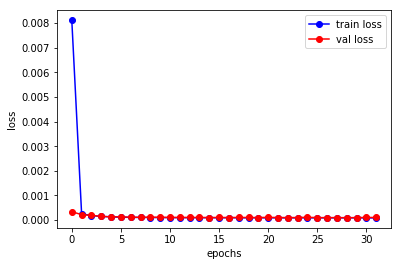

In [52]:
plot_learning_history(history)

Evaluate model performance on test dataset

In [53]:
model.evaluate(X_test, Y_test)

49967/49967 [==============================] - ETA: 5: - ETA: 15s - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 65us/step


0.00010013768517209309

Save model to local file for further use

In [54]:
model.save("rBergomi.h5")

Study the quantiles of the relative error on test dataset

In [55]:
pred_test = model.predict(X_test).flatten()
true_test = Y_test.values.flatten()
relative_error = 100 * np.abs(pred_test - true_test) / true_test

In [56]:
sorted_re = sorted(relative_error)
q_90 = sorted_re[int(0.90*len(relative_error))]
q_95 = sorted_re[int(0.95*len(relative_error))]
q_99 = sorted_re[int(0.99*len(relative_error))]

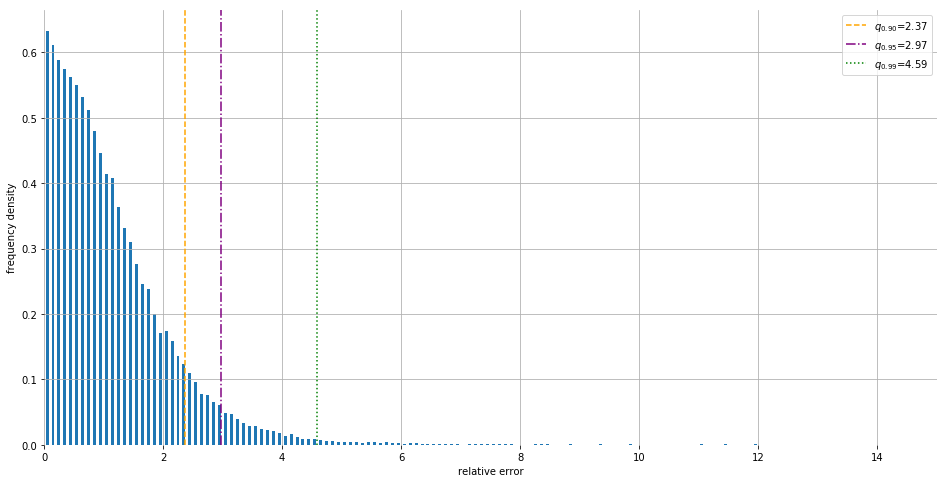

In [57]:
plt.figure(figsize=(16, 8))
plt.hist(relative_error, bins=np.linspace(0, 15, 151), density=True, rwidth=0.5)
plt.xlim((0, 15))
sns.despine(left=True, bottom=True, right=True)
plt.grid(True)
plt.axvline(x=q_90, ls='--', color='orange', label=r"$q_{0.90}$"+"={:.2f}".format(q_90))
plt.axvline(x=q_95, ls='-.', color='purple', label=r"$q_{0.95}$"+"={:.2f}".format(q_95))
plt.axvline(x=q_99, ls=':', color='green', label=r"$q_{0.99}$"+"={:.2f}".format(q_99))
plt.legend(loc=1)
plt.xlabel("relative error")
plt.ylabel("frequency density")
plt.show()

Use a fixed parameter to generate the IV surface

In [58]:
log_moneyness = np.linspace(-0.1, 0.1, 21)
maturity = np.linspace(0.01, 0.18, 18)
log_moneyness, maturity = np.meshgrid(log_moneyness, maturity)

# columns ['Moneyness', 'Time to Maturity (years)', 'H', 'eta', 'rho', 'v0']
df = pd.DataFrame(columns=train.columns)
df['Moneyness'] = np.exp(log_moneyness.flatten())
df['Time to Maturity (years)'] = maturity.flatten()
df['H'] = 0.07
df['eta'] = 1.9
df['rho'] = -0.9
df['v0'] = 0.01

In [59]:
df.head()

,Moneyness,Time to Maturity (years),H,eta,rho,v0,iv
0,0.904837,0.01,0.07,1.9,-0.9,0.01,NaN
1,0.913931,0.01,0.07,1.9,-0.9,0.01,NaN
2,0.923116,0.01,0.07,1.9,-0.9,0.01,NaN
3,0.932394,0.01,0.07,1.9,-0.9,0.01,NaN
4,0.941765,0.01,0.07,1.9,-0.9,0.01,NaN


In [60]:
from utils import rBergomi_pricer

In [61]:
df['iv'] = df.progress_apply(lambda row: rBergomi_pricer(row['H'], row['eta'], row['rho'], row['v0'], 
                                                         row['Time to Maturity (years)'], row['Moneyness'], 1.0)[1], 
                             axis=1)

100%|████████████████████████████████████████████████████████████| 378/378 [04:08<00:00,  1.05s/it]


In [62]:
scaled_features = SCALER.transform(df.iloc[:, :-1])
df['iv_nn'] = model.predict(scaled_features)

In [63]:
df.head()

,Moneyness,Time to Maturity (years),H,eta,rho,v0,iv,iv_nn
0,0.904837,0.01,0.07,1.9,-0.9,0.01,0.335187,0.295085
1,0.913931,0.01,0.07,1.9,-0.9,0.01,0.299937,0.282478
2,0.923116,0.01,0.07,1.9,-0.9,0.01,NaN,0.269683
3,0.932394,0.01,0.07,1.9,-0.9,0.01,0.258311,0.256740
4,0.941765,0.01,0.07,1.9,-0.9,0.01,NaN,0.243267


In [71]:
df['Log Moneyness'] = log_moneyness.flatten()
df['re'] = np.abs(df['iv_nn'] - df['iv']) / df['iv']

In [70]:
df.dropna(inplace=True)

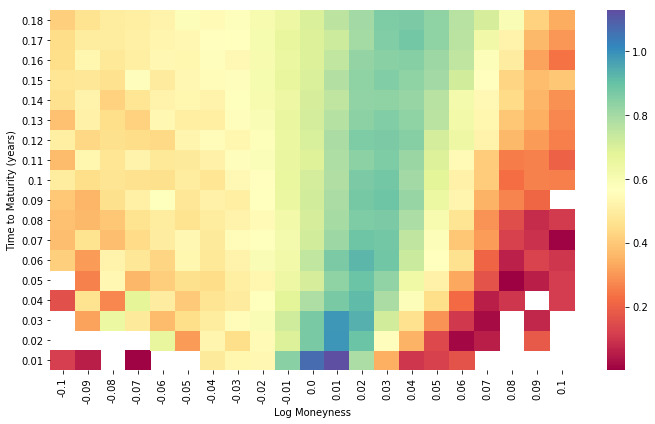

In [73]:
plot_heatmap(df, 're')

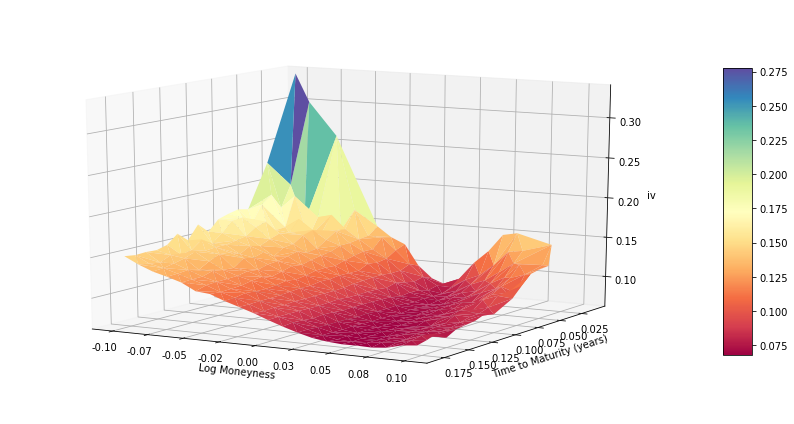

In [74]:
plot_iv_surface(df, z='iv')

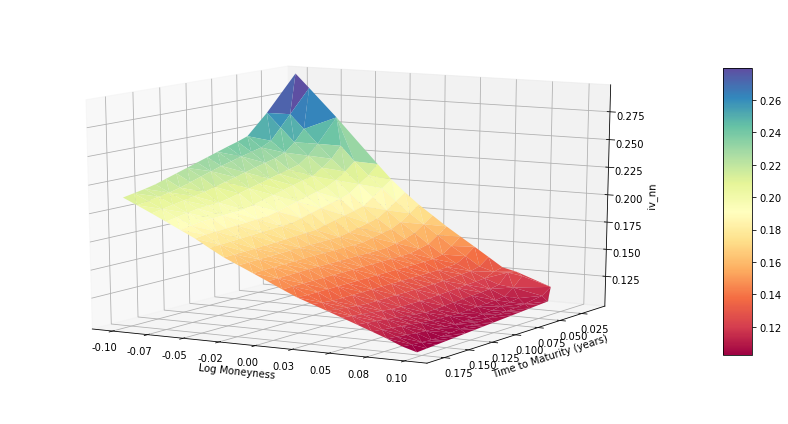

In [75]:
plot_iv_surface(df, z='iv_nn')

-----

-----

# Deep Calibration

This part implements the Deep calibration algorithm (LM combined with NN regression)

In [76]:
from utils import heston_pricer, rBergomi_pricer

Define a model parameters initializer, which will be used to initialize the model parameters before the LM calibrating loop

In [97]:
from scipy.stats import truncnorm

def model_parameters_initializer(model='heston', random_seed=None):
    """ Initialize model parameters
    """
    if model == 'heston':
        params = [
            10 * np.random.rand(), # lambda
            np.random.rand(), # vbar
            5 * np.random.rand(), # eta
            -1 * np.random.rand(), # rho
            np.random.rand() #v0
        ]
        names = ['lambda', 'vbar', 'eta', 'rho', 'v0']
    elif model == 'rbergomi' or model == 'rBergomi':
        params = [
            truncnorm.rvs(-1.2, 8.6, 0.07, 0.05), # H
            truncnorm.rvs(-3, 3, 2.5, 0.5), # eta
            truncnorm.rvs(-0.25, 2.25, -0.95, 0.2), # rho
            truncnorm.rvs(-2.5, 7, 0.3, 0.1) # v0
        ]
        names = ['H', 'eta', 'rho', 'v0']
    else:
        raise NameError("No such model name: {}".format(model))
    return params, names

Define a function to return the prediction and the Jacobian matrix of a neural network w.r.t. a specific input

In [77]:
def predict_label_jac(sess, model, test_inputs):
    """ Use a trained model to predict and to return jacobian matrix
    """
    pred = model.predict(test_inputs)
    grad_func = tf.gradients(model.output, model.input)
    jac = sess.run(grad_func, feed_dict={model.input: test_inputs})[0]
    return pred, jac

In [124]:
def deep_calibration(tf_sess, nn, K_T, market_quotes, model_name='heston', lambd_init=0.1, beta0=0.25, beta1=0.75, max_iter=1000, tol=1e-8):
    """ Combines LM algorithm with a NN regressor to calibrating model parameters.
    """
    # initialize model parameters
    params, param_names = model_parameters_initializer(model_name)
    
    # initalize learning step
    lambd = lambd_init
    
    n_samples = K_T.shape[0]
    n_params = len(params)
    I = np.eye(n_params)
    Q = market_quotes.reshape((-1, 1)) # shape: [n_samples, 1]
    K_T_values = K_T.values
    
    iter_count = 0
    
    # history to store some useful information during training 
    history = {
        'delta_params': {k: [] for k in param_names},
        'R': [],
        'lambda': [],
        'c_mu': []
    }
    
    # build a input dataframe by combining K_T and model parameters
    input_data = np.insert(K_T_values, [2]*n_params, params, axis=1) # shape: [n_samples, n_params+2]
    iv_nn, J = predict_label_jac(tf_sess, nn, input_data)
    R = iv_nn - Q # shape: [n_samples, 1]
    J = J[:, 2:] # shape: [n_samples, n_params], excluding K and T
    delta_params = np.linalg.pinv(J.T.dot(J) + lambd * I).dot(J.T.dot(R)).flatten() # vector size: [n_params,]
    
    history['R'].append(np.linalg.norm(R))
    history['lambda'].append(lambd)
    for param_idx, param_name in enumerate(param_names):
        history['delta_params'][param_name].append(delta_params[param_idx])

    while iter_count < max_iter and np.linalg.norm(delta_params) > tol:
        if iter_count % 50 == 0:
            logging.info("{}/{} iteration".format(iter_count+1, max_iter))
        params_new = params - delta_params
        input_data_new = np.insert(K_T_values, [2]*n_params, params_new, axis=1)
        iv_nn_new, J_new = predict_label_jac(tf_sess, nn, input_data_new)
        R_new = iv_nn_new - Q
        J_new = J_new[:, 2:]
        R_norm = np.linalg.norm(R)
        c_mu = (R_norm - np.linalg.norm(R_new)) / (R_norm - np.linalg.norm(R - J.dot(delta_params)))
        
        history['c_mu'].append(c_mu)
        
        if c_mu <= beta0:
            # reject delta_params
            lambd *= 2 # too slow, use greater lambd
        else:
            params = params_new
            R = R_new
            J = J_new
        if c_mu >=beta1:
            lambd /= 2.0
        
        delta_params = np.linalg.pinv(J.T.dot(J) + lambd * I).dot(J.T.dot(R)).flatten() # vector size: [n_params, ]
        iter_count += 1
        
        history['R'].append(np.linalg.norm(R))
        history['lambda'].append(lambd)
        for param_idx, param_name in enumerate(param_names):
            history['delta_params'][param_name].append(delta_params[param_idx])
    if iter_count < max_iter:
        logging.info("Leave iterations after {} iters".format(iter_count))
        
    return dict(zip(param_names, params)), history

In [80]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [81]:
K_T = X_test.iloc[:500, :2]
K_T_origin = X_test_origin.iloc[:500, :2]

In [82]:
# Market parameters
S0 = 1
r = 0 

# Heston parameters 
lambd = 1.3253 
vbar = 0.0354 
eta = 0.3877 
rho = -0.7165 
v0 = 0.0174 
q = 0

market_quotes = np.array([heston_pricer(lambd, vbar, eta, rho, v0, r, q, K_T_origin.iloc[i, 1], S0, K_T_origin.iloc[i, 0])[1] for i in range(K_T.shape[0])])
market_quotes = market_quotes.reshape((-1, 1))

In [83]:
valid_idx = ~np.isnan(market_quotes.flatten())
K_T_input = K_T.iloc[valid_idx, :]
market_quotes = market_quotes[valid_idx, :]

In [125]:
params, history = deep_calibration(sess, model, K_T_input, market_quotes, model_name='rBergomi', lambd_init=0.01, beta0=0.25, beta1=0.75, max_iter=1000)

2019-04-14 17:40:48,497 - INFO - 1/1000 iteration
2019-04-14 17:41:03,531 - INFO - Leave iterations after 41 iters


In [126]:
# Heston parameters 
# eta = 0.3877 
# rho = -0.7165 
# lambd = 1.3253 
# vbar = 0.0354 
# v0 = 0.0174 

# rBergomi parameters
# eta = 1.9
# rho = -0.9
# H = 0.07
# v0 = 0.01

params

{'H': 0.053170766461822644,
 'eta': 2.511886952147878,
 'rho': -0.783350054411841,
 'v0': 0.11608982064266887}

In [133]:
mu_hat = pd.DataFrame([params.values()], columns=params.keys())
mu_hat['Moneyness'] = 0
mu_hat['Time to Maturity (years)'] = 0
SCALER.inverse_transform(mu_hat)

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,0.083191,0.874198,0.208411,3.742134,-0.921128,0.313406
